# Static train ridership on the Swedish railways 2024.

This is a static analysis of train ridership on the Swedish railways during 2024!

## Read Sampers data

In [2]:
import pandas as pd
import os
import warnings

# Suppress warnings (e.g., from pandas or others)
warnings.filterwarnings("ignore")

# Get the current working directory
current_directory = os.getcwd()

# File path (assuming the CSV file is named 'Sampers-pax-2018-cleaned.csv')
file_path_sampers = os.path.join(current_directory, 'data', 'Sampers-pax-2024-cleaned.csv')

# Read the CSV file into a DataFrame
df_pax = pd.read_csv(file_path_sampers, sep=';', low_memory=False, dtype={"line": str})  # Force 'line' column as string

# Define a function to replace commas with dots and remove hidden characters
def clean_column_values(value):
    if isinstance(value, str):
        value = value.replace(',', '.')  # Replace commas with dots for decimals
        value = value.replace('\r', '').replace('\n', '')  # Remove carriage returns and line breaks
    return value

# Apply cleaning to all columns
for column in df_pax.columns:
    if df_pax[column].dtype == 'object':
        df_pax[column] = df_pax[column].apply(clean_column_values)

# Convert all columns except the first three to numeric
numeric_columns = df_pax.columns[3:]  # Select all columns starting from the 4th (index 3)
df_pax[numeric_columns] = df_pax[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [3]:
df_pax.columns

Index(['line', 'Station', 'Nat pr PÅ', 'Nat tj PÅ', 'Nat arb PÅ', 'Reg arb PÅ',
       'Reg tj PÅ', 'Reg övr PÅ', 'Nat pr AV', 'Nat tj AV', 'Nat arb AV',
       'Reg arb AV', 'Reg tj AV', 'Reg övr AV'],
      dtype='object')

## Passengers ombord

A new data structure where the number of passengers ombord is calculated.

In [ ]:
# Columns for boardings and alightings
boarding_cols = ["Nat pr PÅ", "Nat tj PÅ", "Nat arb PÅ", "Reg arb PÅ", "Reg tj PÅ", "Reg övr PÅ"]
alighting_cols = ["Nat pr AV", "Nat tj AV", "Nat arb AV", "Reg arb AV", "Reg tj AV", "Reg övr AV"]

df_pax[boarding_cols] = df_pax[boarding_cols].astype(float)
df_pax[alighting_cols] = df_pax[alighting_cols].astype(float)

# Initialize a list to store the results
data = []

# Group by 'line' and process each group separately
for line, group in df_pax.groupby("line"):
    # Reset the index for each group to ensure sequential processing
    group = group.reset_index(drop=True)

    # Initialize onboard counters for each category of passengers
    onboard = {col: 0 for col in boarding_cols}

    for i in range(len(group) - 1):
        # Add boardings at the current station
        for col in boarding_cols:
            onboard[col] += group.loc[i, col]

        # Append the data for the current segment (from the current station to the next)
        data.append({
            "Linje": line,
            "från": group.loc[i, "Station"],
            "till": group.loc[i + 1, "Station"],
            "ombord_pr_nat": onboard["Nat pr PÅ"],
            "ombord_tj_nat": onboard["Nat tj PÅ"],
            "ombord_arb_nat": onboard["Nat arb PÅ"],
            "ombord_arb_reg": onboard["Reg arb PÅ"],
            "ombord_tj_reg": onboard["Reg tj PÅ"],
            "ombord_övr_reg": onboard["Reg övr PÅ"],
        })

        # Subtract alightings for the current station (these apply to the next segment)
        for b_col, a_col in zip(boarding_cols, alighting_cols):
            onboard[b_col] -= group.loc[i, a_col]

# Convert the list to a DataFrame
new_df_pax = pd.DataFrame(data)

## Plotting 

We first plot the ridership (pax ombord) for some random southbound lines.

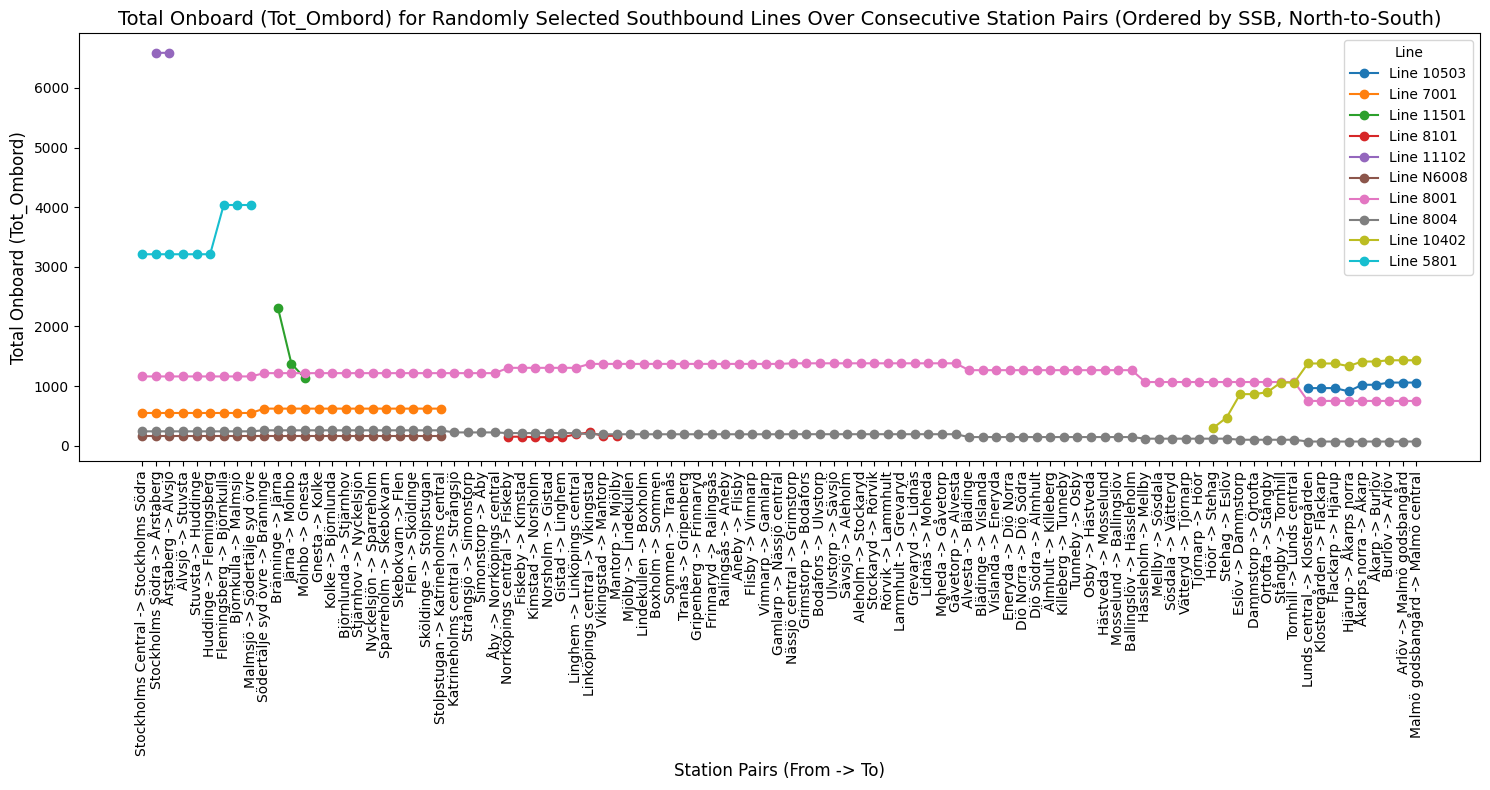

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set up the plot for southbound trains with the original order of stations on the x-axis
plt.figure(figsize=(15, 8))

# Generate all possible consecutive station pairs in the original order (north-to-south)
consecutive_pairs_south = [
    f"{stations_SSB_ordered_north_to_south[i]} -> {stations_SSB_ordered_north_to_south[i + 1]}"
    for i in range(len(stations_SSB_ordered_north_to_south) - 1)
]

# Filter the data to include only rows where the train is going south
southbound_df = filtered_df_pax[filtered_df_pax['Direction'] == 'South']

# Choose a random set of 10 unique lines for southbound trains
unique_lines_south = southbound_df['line'].unique()
random_lines_south = np.random.choice(unique_lines_south, size=10, replace=False)

# Get a colormap for 10 distinct colors
colors = plt.cm.get_cmap('tab10', len(random_lines_south))

# Create a placeholder DataFrame for the x-axis to keep the same order
full_x_axis_df_south = pd.DataFrame({'Station_Pair': consecutive_pairs_south})

# Iterate over each of the 10 randomly selected southbound lines
for i, line in enumerate(random_lines_south):
    # Filter data for the specific line
    line_df = southbound_df[southbound_df['line'] == line]

    # Create a list of station pairs for the line
    line_df['Station_Pair'] = line_df['From'] + ' -> ' + line_df['To']
    # Set 'Pair_Index' based on consecutive pairs list
    line_df['Pair_Index'] = line_df['Station_Pair'].apply(lambda x: consecutive_pairs_south.index(x) if x in consecutive_pairs_south else -1)
    line_df = line_df[line_df['Pair_Index'] >= 0]  # Filter out invalid pairs
    line_df = line_df.sort_values(by='Pair_Index')  # Sort based on the custom pair index

    # Determine the portion of the SSB line that this train covers
    min_index = line_df['Pair_Index'].min()  # Start of the covered section
    max_index = line_df['Pair_Index'].max()  # End of the covered section

    # Reindex the DataFrame to ensure all consecutive pairs within the covered section are present
    covered_pairs = consecutive_pairs_south[min_index:max_index + 1]  # Only the covered pairs
    reindexed_df = pd.DataFrame({'Station_Pair': covered_pairs})
    merged_df = pd.merge(reindexed_df, line_df, on='Station_Pair', how='left')

    # Fill in missing Tot_Ombord values by using the value from the previous station pair
    merged_df['Tot_Ombord'] = merged_df['Tot_Ombord'].fillna(method='ffill')

    # Merge with the full x-axis DataFrame to ensure the order is maintained on the x-axis
    final_df = pd.merge(full_x_axis_df_south, merged_df, on='Station_Pair', how='left')

    # Plot the line with a distinct color
    plt.plot(
        final_df['Station_Pair'], 
        final_df['Tot_Ombord'], 
        label=f'Line {line}', 
        color=colors(i), 
        marker='o'
    )

# Set labels, title, and legend
plt.xlabel('Station Pairs (From -> To)', fontsize=12)
plt.ylabel('Total Onboard (Tot_Ombord)', fontsize=12)
plt.title('Total Onboard (Tot_Ombord) for Randomly Selected Southbound Lines Over Consecutive Station Pairs (Ordered by SSB, North-to-South)', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Line', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


Similar plot for north going trains.

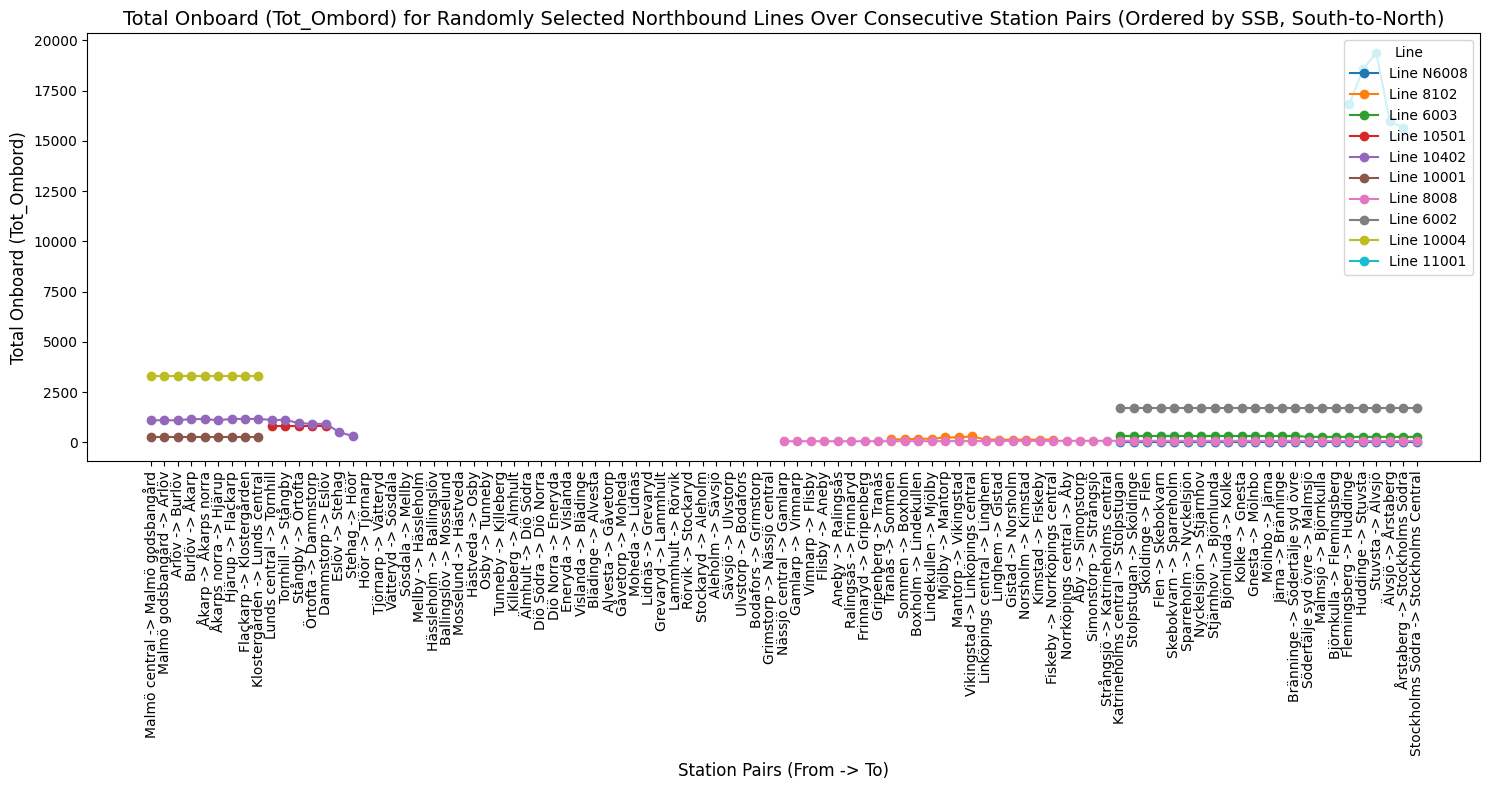

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set up the plot for northbound trains with the inverse order of stations on the x-axis
plt.figure(figsize=(15, 8))

# Reverse the station order for northbound plot
stations_SSB_ordered_south_to_north = stations_SSB_ordered_north_to_south[::-1]

# Generate all possible consecutive station pairs in the reversed order
consecutive_pairs_north = [
    f"{stations_SSB_ordered_south_to_north[i]} -> {stations_SSB_ordered_south_to_north[i + 1]}"
    for i in range(len(stations_SSB_ordered_south_to_north) - 1)
]

# Filter the data to include only rows where the train is going north
northbound_df = filtered_df_pax[filtered_df_pax['Direction'] == 'North']

# Choose a random set of 10 unique lines for northbound trains
unique_lines_north = northbound_df['line'].unique()
random_lines_north = np.random.choice(unique_lines_north, size=10, replace=False)

# Get a colormap for 10 distinct colors
colors = plt.cm.get_cmap('tab10', len(random_lines_north))

# Create a placeholder DataFrame for the x-axis to keep the same order
full_x_axis_df = pd.DataFrame({'Station_Pair': consecutive_pairs_north})

# Iterate over each of the 10 randomly selected northbound lines
for i, line in enumerate(random_lines_north):
    # Filter data for the specific line
    line_df = northbound_df[northbound_df['line'] == line]

    # Create a list of station pairs for the line
    line_df['Station_Pair'] = line_df['From'] + ' -> ' + line_df['To']
    # Set 'Pair_Index' based on consecutive pairs list
    line_df['Pair_Index'] = line_df['Station_Pair'].apply(lambda x: consecutive_pairs_north.index(x) if x in consecutive_pairs_north else -1)
    line_df = line_df[line_df['Pair_Index'] >= 0]  # Filter out invalid pairs
    line_df = line_df.sort_values(by='Pair_Index')  # Sort based on the custom pair index

    # Determine the portion of the SSB line that this train covers
    min_index = line_df['Pair_Index'].min()  # Start of the covered section
    max_index = line_df['Pair_Index'].max()  # End of the covered section

    # Reindex the DataFrame to ensure all consecutive pairs within the covered section are present
    covered_pairs = consecutive_pairs_north[min_index:max_index + 1]  # Only the covered pairs
    reindexed_df = pd.DataFrame({'Station_Pair': covered_pairs})
    merged_df = pd.merge(reindexed_df, line_df, on='Station_Pair', how='left')

    # Fill in missing Tot_Ombord values by using the value from the previous station pair
    merged_df['Tot_Ombord'] = merged_df['Tot_Ombord'].fillna(method='ffill')

    # Merge with the full x-axis DataFrame to ensure the order is maintained on the x-axis
    final_df = pd.merge(full_x_axis_df, merged_df, on='Station_Pair', how='left')

    # Plot the line with a distinct color
    plt.plot(
        final_df['Station_Pair'], 
        final_df['Tot_Ombord'], 
        label=f'Line {line}', 
        color=colors(i), 
        marker='o'
    )

# Set labels, title, and legend
plt.xlabel('Station Pairs (From -> To)', fontsize=12)
plt.ylabel('Total Onboard (Tot_Ombord)', fontsize=12)
plt.title('Total Onboard (Tot_Ombord) for Randomly Selected Northbound Lines Over Consecutive Station Pairs (Ordered by SSB, South-to-North)', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Line', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


## Exporting to excel file

In [12]:
filtered_df_pax.columns

Index(['line', 'From', 'To', 'Nat_Priv_Ombord', 'Nat_Tj_Ombord',
       'Reg_arb_Ombord', 'Reg_tj_Ombord', 'Reg_övr_Ombord',
       'Nationella_tot_Ombord', 'Regionala_tot_Ombord', 'Tot_Ombord',
       'Nat_Priv_Påstigande', 'Nat_Tj_Påstigande', 'Reg_arb_Påstigande',
       'Reg_tj_Påstigande', 'Reg_övr_Påstigande', 'Nationella_tot_Påstigande',
       'Regionala_tot_Påstigande', 'Totalt Påstigande', 'Nat_Priv_Avstigande',
       'Nat_Tj_Avstigande', 'Reg_arb_Avstigande', 'Reg_tj_Avstigande',
       'Reg_övr_Avstigande', 'Nationella_tot_Avstigande',
       'Regionala_tot_Avstigande', 'Tot_Avstigande', 'Direction'],
      dtype='object')

In [13]:
# Ensure the 'line' column is treated as text (string type)
filtered_df_pax['line'] = filtered_df_pax['line'].astype(str)

# Save the DataFrame to an Excel file
output_filename = "static_pass_SSB_2018.xlsx"
filtered_df_pax.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")

Data successfully saved to static_pass_SSB_2018.xlsx
